# Weather Prediction - Week 07 - Spiced Data Science Bootcamp - Valentin Lorenzen

## Initialization

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [3]:
# loading data
df = pd.read_csv("data/TG_STAID002759.txt", parse_dates=True, index_col=1)

In [4]:
# clean column names
df.columns = ['SOUID', 'temp', 'Q_temp']

In [5]:
# drop unnecessary columns
df.drop(['SOUID', 'Q_temp'], axis=1, inplace=True)

In [6]:
# multiply temperature feature by 0.1
df['temp'] = df['temp'] * 0.1

In [7]:
# add date columns
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

In [8]:
# drop everything before 1945 because of missing values
df = df.loc[df['year']>1945]

In [9]:
# split data
weather = df[:-365]
weather_remainder_remainder_test = df[-365:]

## EDA

<AxesSubplot:xlabel='    DATE', ylabel='temp'>

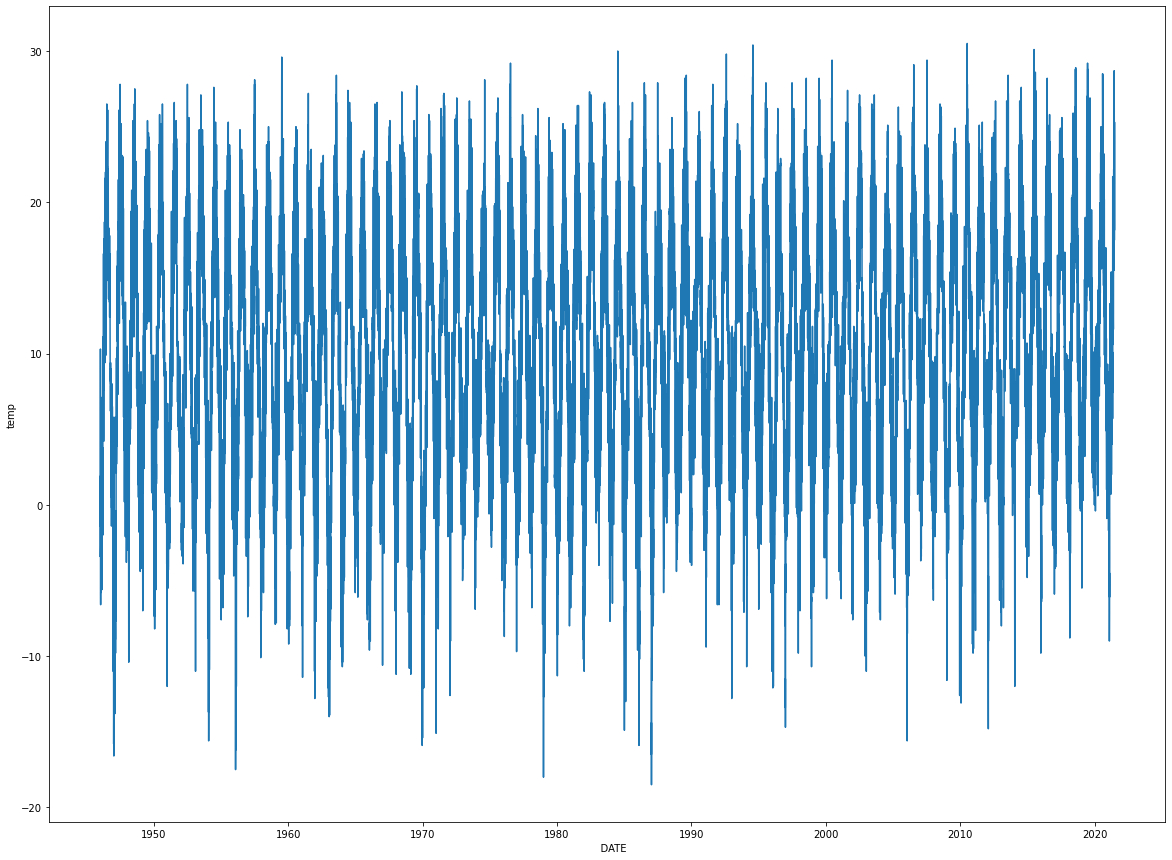

In [10]:
# Temperature over the years
fig = plt.gcf()
fig.set_size_inches(20, 15)
sns.lineplot(data=weather, x=weather.index, y="temp")

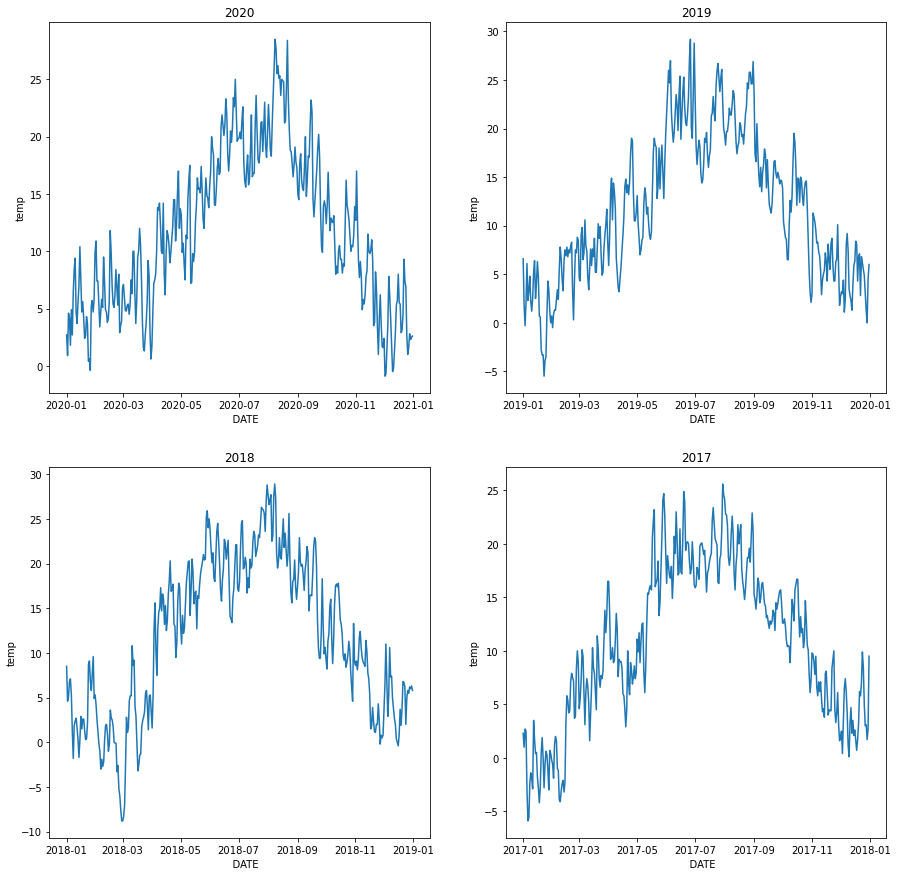

In [11]:
fig, ax = plt.subplots(2, 2, figsize=[15,15])

sns.lineplot(data=weather.loc[df['year']==2020], x=weather.loc[df['year']==2020].index, y="temp", ax=ax[0,0])

sns.lineplot(data=weather.loc[df['year']==2019], x=weather.loc[df['year']==2019].index, y="temp", ax=ax[0,1])

sns.lineplot(data=weather.loc[df['year']==2018], x=weather.loc[df['year']==2018].index, y="temp", ax=ax[1,0])

sns.lineplot(data=weather.loc[df['year']==2017], x=weather.loc[df['year']==2017].index, y="temp", ax=ax[1,1])

ax[0,0].title.set_text('2020')

ax[0,1].title.set_text('2019')

ax[1,0].title.set_text('2018')

ax[1,1].title.set_text('2017')



<AxesSubplot:xlabel='    DATE', ylabel='temp'>

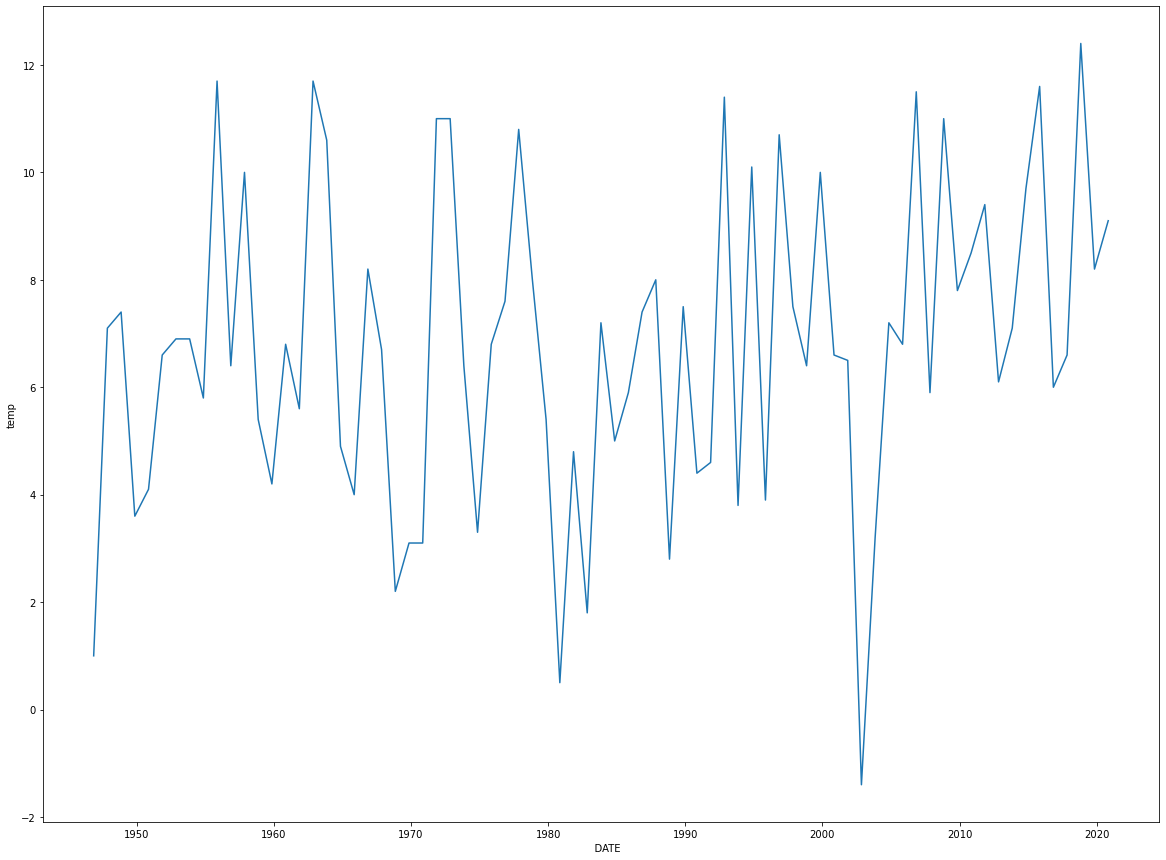

In [12]:
fig = plt.gcf()
fig.set_size_inches(20, 15)
sns.lineplot(data=weather.loc[weather['month']==11].loc[weather['day']==6], x=weather.loc[weather['month']==11].loc[weather['day']==6].index, y="temp")

## Linear Regression

In [13]:
weather['timestep'] = list(range(len(weather)))

/tmp/ipykernel_24459/4203461303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['timestep'] = list(range(len(weather)))


In [14]:
y_trend = weather.copy().iloc[:,0]
X_trend = weather.copy()['timestep'].values.reshape(-1,1)

In [15]:
trend_model = LinearRegression()

In [16]:
trend_model.fit(X_trend, y_trend)

LinearRegression()

In [17]:
weather['trend'] = trend_model.predict(X_trend)

/tmp/ipykernel_24459/1382191535.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['trend'] = trend_model.predict(X_trend)


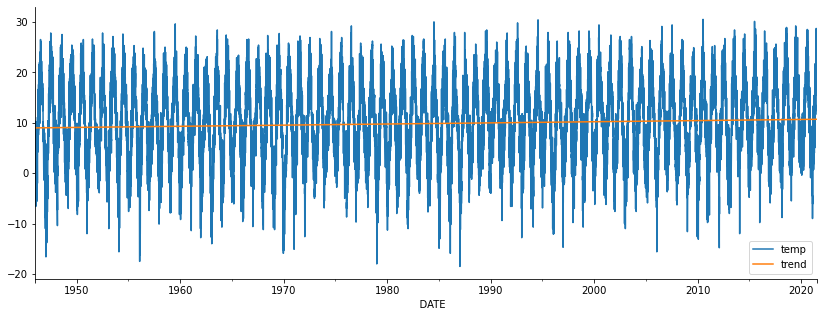

In [18]:
weather[['temp','trend']].plot(figsize=(14,5),legend=True)
sns.despine()

In [19]:
weather['detrended'] = weather['temp'] - weather['trend']

/tmp/ipykernel_24459/522069733.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['detrended'] = weather['temp'] - weather['trend']


In [20]:
seasonal_dummies = pd.get_dummies(weather.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(weather.index)

weather = pd.concat([weather, seasonal_dummies], axis=1)

In [21]:
weather.columns

Index(['temp', 'year', 'month', 'day', 'timestep', 'trend', 'detrended',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

In [22]:
X_seasonality = weather[weather.columns[-11:]]
y_seasonality = weather['detrended']

In [23]:
seasonality_model = LinearRegression()

In [24]:
seasonality_model.fit(X_seasonality, y_seasonality)

LinearRegression()

In [25]:
weather['seasonality'] = seasonality_model.predict(X_seasonality)

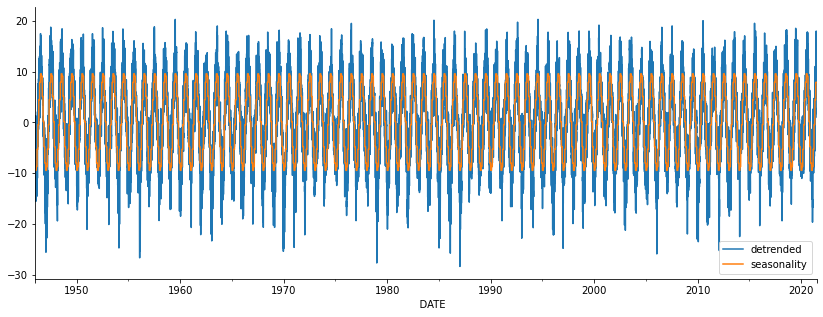

In [26]:
weather[['detrended','seasonality']].plot(figsize=(14,5),legend=True)
sns.despine()

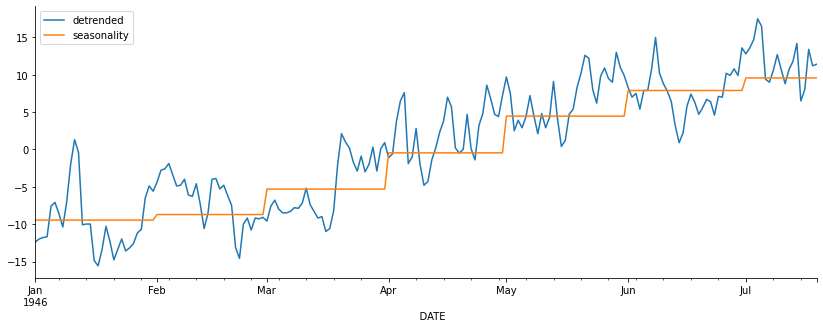

In [27]:
nr_rows = int(input('How many rows?'))

weather[['detrended','seasonality']][:nr_rows].plot(figsize=(14,5),legend=True)
sns.despine()

In [28]:
weather['trend_seasonal'] = weather['trend'] + weather['seasonality']

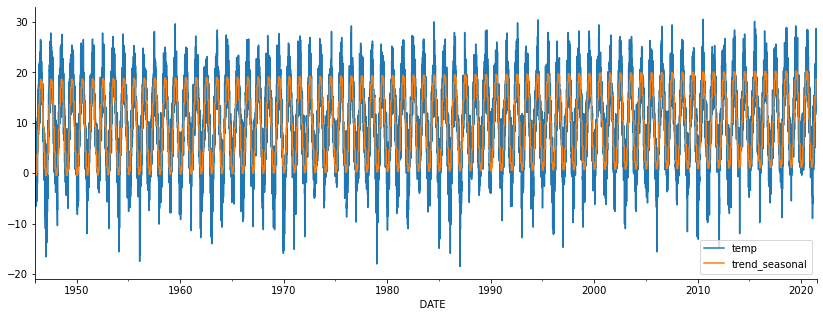

In [29]:
weather[['temp','trend_seasonal']].plot(figsize=(14,5),legend=True)
sns.despine()

In [30]:
weather['remainder'] = weather['temp'] - weather['trend_seasonal']

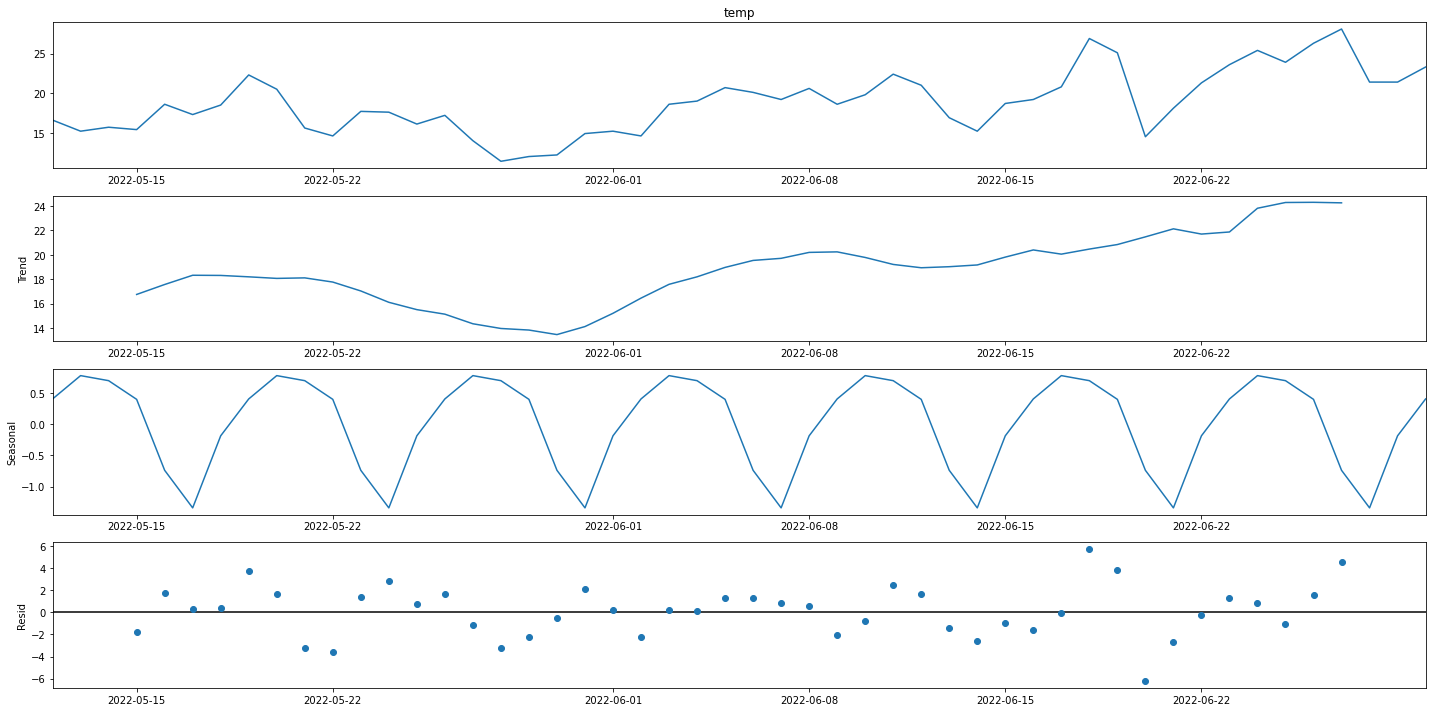

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

sd = seasonal_decompose(df['temp'].iloc[-50:], model='additive')

plt.rcParams['figure.figsize'] = (20,10)
sd.plot()
None

In [32]:
weather_remainder = weather[['remainder']]

In [33]:
weather_remainder

remainder
    DATE             
1946-01-01  -2.927023
1946-01-02  -2.527085
1946-01-03  -2.327147
1946-01-04  -2.227208
1946-01-05   1.872730
...               ...
2021-06-26   2.915186
2021-06-27   3.515124
2021-06-28   6.715063
2021-06-29   5.515001
2021-06-30  -0.385061

[27575 rows x 1 columns]

In [34]:
# maximum interval to consider
p = 3
lags = [i+1 for i in range(p)]

for lag in lags:
    column_name = 'lag' + str(lag)
    weather_remainder[column_name] = weather_remainder['remainder'].shift(lag)

/tmp/ipykernel_24459/1497048265.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_remainder[column_name] = weather_remainder['remainder'].shift(lag)


/home/valentin/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/valentin/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/valentin/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warning

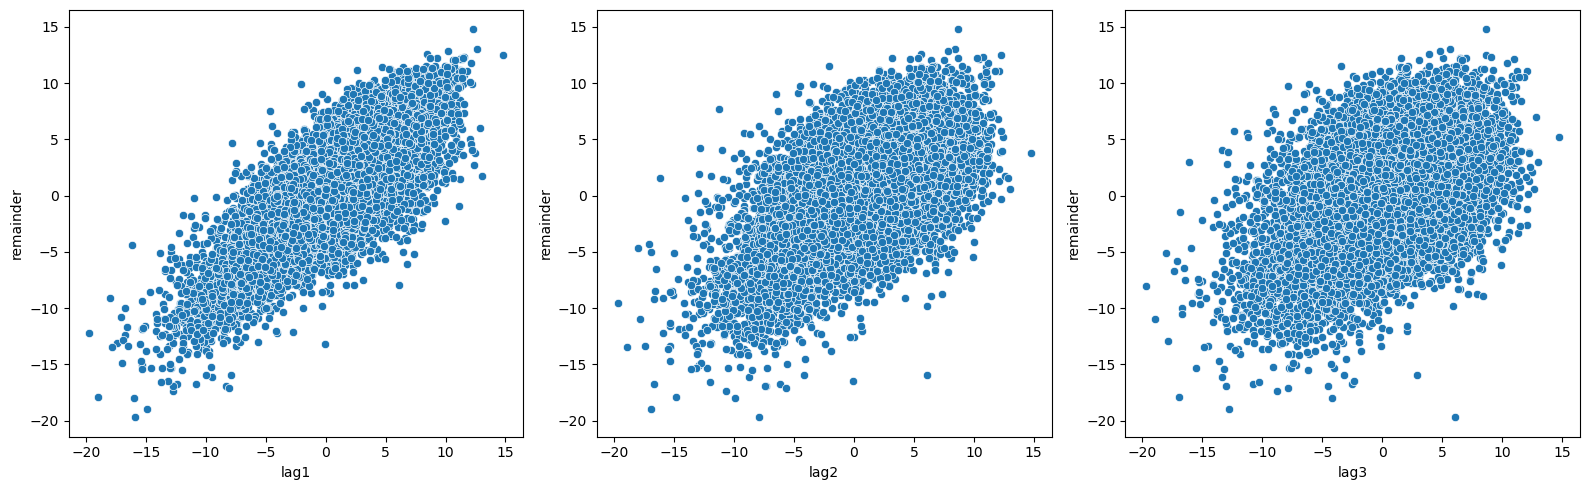

In [35]:
import matplotlib.gridspec as gridspec
#sns.set() # set seaborn as default style

lag_columns = weather_remainder.columns[-p:]
fig, axes = plt.subplots(1,p, figsize=(16,5),dpi=100)
gs = gridspec.GridSpec(1,p)

for i in range(p):
    sns.scatterplot(weather_remainder[lag_columns[i]],weather_remainder['remainder'],ax=axes[i])
    
plt.tight_layout()

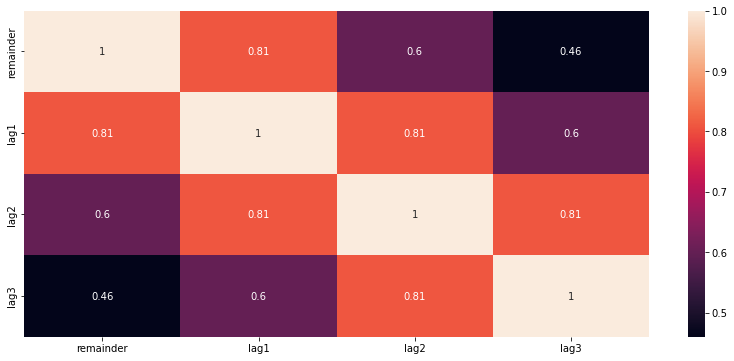

In [36]:
plt.rcParams['figure.figsize'] = (14,6)
sns.heatmap(round(weather_remainder.corr(),2), annot=True)
None

In [37]:
weather_remainder.dropna(inplace=True)
weather_remainder.head()

/tmp/ipykernel_24459/2669563194.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_remainder.dropna(inplace=True)


remainder      lag1      lag2      lag3
    DATE                                           
1946-01-04  -2.227208 -2.327147 -2.527085 -2.927023
1946-01-05   1.872730 -2.227208 -2.327147 -2.527085
1946-01-06   2.372668  1.872730 -2.227208 -2.327147
1946-01-07   0.872606  2.372668  1.872730 -2.227208
1946-01-08  -0.927456  0.872606  2.372668  1.872730

In [38]:
X_remainder = weather_remainder[lag_columns]
y_remainder = weather_remainder['remainder']

In [39]:
ar_model = LinearRegression()
ar_model.fit(X_remainder,y_remainder)

LinearRegression()

In [40]:
weather_remainder['ar_predictions'] = ar_model.predict(X_remainder)

/tmp/ipykernel_24459/2406550059.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_remainder['ar_predictions'] = ar_model.predict(X_remainder)


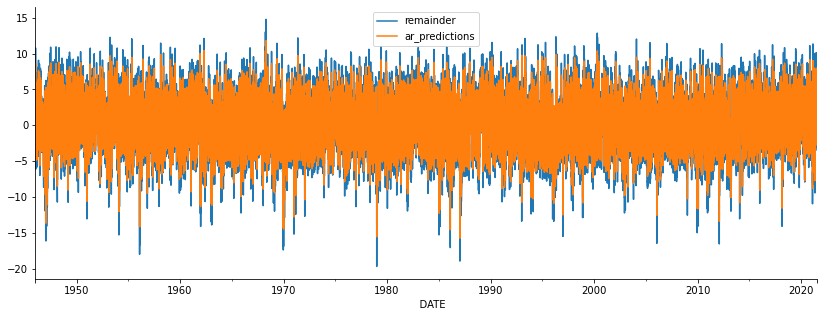

In [41]:
weather_remainder[['remainder','ar_predictions']].plot(figsize=(14,5),legend=True)
sns.despine()

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Text(0, 0.5, 'Autocorrelation')

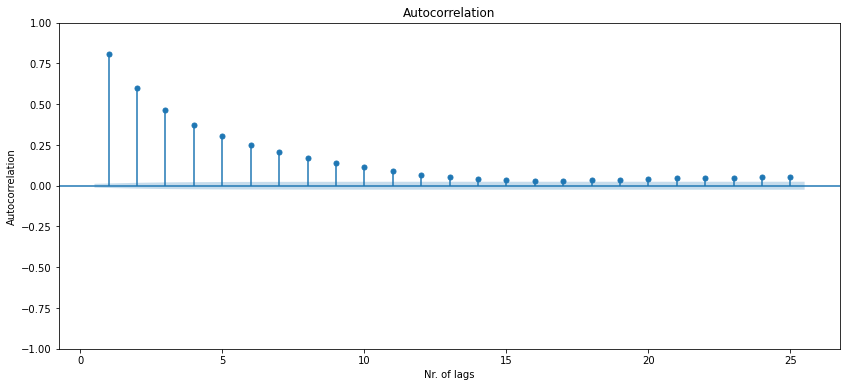

In [43]:
plot_acf(weather_remainder['remainder'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation')

/home/valentin/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


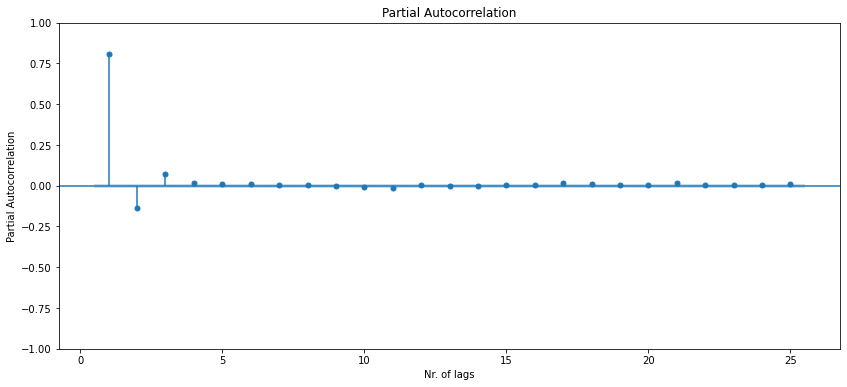

In [44]:
plot_pacf(weather_remainder['remainder'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation')
None

In [45]:
weather_remainder['residuals_ar'] = weather_remainder['remainder'] - weather_remainder['ar_predictions']

/tmp/ipykernel_24459/1351734198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_remainder['residuals_ar'] = weather_remainder['remainder'] - weather_remainder['ar_predictions']


In [46]:
import pmdarima as pm

In [60]:
a_a = pm.auto_arima(weather['remainder'], 
                  seasonal=False, 
                  maxiter=100, 
                  m=365, 
                  d=1,
                  D=1,
                  n_jobs=-1,
                  trace=True)

/home/valentin/anaconda3/lib/python3.9/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (365) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/home/valentin/anaconda3/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=84.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=128044.921, Time=0.97 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=128025.724, Time=2.91 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=128014.324, Time=4.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=128042.921, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=36.98 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=126943.254, Time=5.76 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=35.63 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=126200.531, Time=8.72 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=48.73 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=125797.418, Time=13.99 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=89.86 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=125410.663, Time=21.45 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=108.95 sec
 ARIMA(0,1,5)(0,0,0)[0]             : 

In [76]:
weather['remainder']

    DATE
1946-01-01   -2.927023
1946-01-02   -2.527085
1946-01-03   -2.327147
1946-01-04   -2.227208
1946-01-05    1.872730
                ...   
2021-06-26    2.915186
2021-06-27    3.515124
2021-06-28    6.715063
2021-06-29    5.515001
2021-06-30   -0.385061
Name: remainder, Length: 27575, dtype: float64

In [86]:
y_forecast, ci = a_a.predict(3, return_conf_int=True)

In [87]:
y_forecast

array([-0.89775006, -0.21290048,  0.3500311 ])

In [ ]:
final_prediction = trend_p

## Facebook Prophet

In [ ]:
from prophet import Prophet
import pandas as pd

In [ ]:
df_auto = pd.read_csv("data/TG_STAID002759.txt", parse_dates=True)

In [ ]:
df_auto.columns = ['1', 'ds', 'y', '2']

In [ ]:
df_auto.drop(['1', '2'], axis=1, inplace=True)

In [ ]:
df_auto['ds'] = pd.to_datetime(df_auto['ds'], format="%Y%m%d")
df_auto['y'] = df_auto['y'] * 0.1

In [ ]:
df_auto = df_auto[-18250:]

In [ ]:
365*50

18250

In [ ]:
pr = Prophet(yearly_seasonality=True)

In [ ]:
pr.fit(df_auto)

12:14:12 - cmdstanpy - INFO - Chain [1] start processing
12:14:15 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
future = pr.make_future_dataframe(periods=365)
future.tail()

ds
18610 2023-06-26
18611 2023-06-27
18612 2023-06-28
18613 2023-06-29
18614 2023-06-30

In [ ]:
forecast = pr.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
18250 2022-07-01  20.343423   15.556390   25.145290
18251 2022-07-02  20.335896   15.230940   25.028592
18252 2022-07-03  20.447563   15.693290   25.094215
18253 2022-07-04  20.622231   15.714015   25.350661
18254 2022-07-05  20.665711   15.486188   25.595875

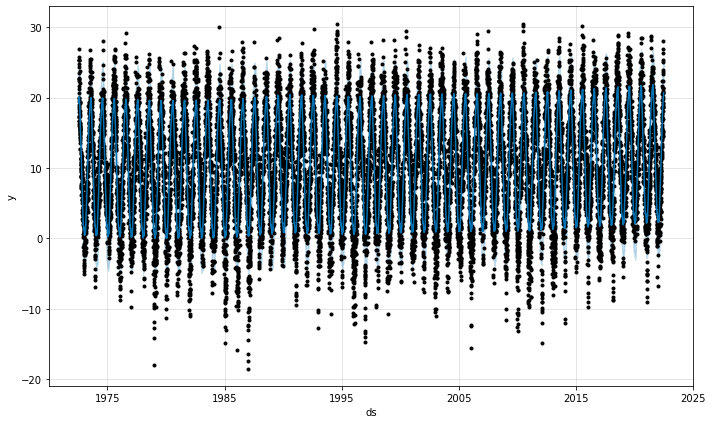

In [ ]:
fig1 = pr.plot(forecast)

In [ ]:
forecast

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0     1972-07-13   9.799406   14.410862   24.362704     9.799406     9.799406   
1     1972-07-14   9.799200   14.183491   23.574998     9.799200     9.799200   
2     1972-07-15   9.798993   14.203584   23.970756     9.798993     9.798993   
3     1972-07-16   9.798787   14.540361   24.193686     9.798787     9.798787   
4     1972-07-17   9.798581   14.833059   24.587113     9.798581     9.798581   
...          ...        ...         ...         ...          ...          ...   
18250 2022-07-01  11.644450   15.556390   25.145290    11.644450    11.644450   
18251 2022-07-02  11.644750   15.230940   25.028592    11.644750    11.644750   
18252 2022-07-03  11.645050   15.693290   25.094215    11.645050    11.645050   
18253 2022-07-04  11.645350   15.714015   25.350661    11.645350    11.645350   
18254 2022-07-05  11.645650   15.486188   25.595875    11.645650    11.645650   

       additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0            9.473171              9.473171              9.473171  0.044098   
1            9.443240              9.443240              9.443240 -0.038904   
2            9.428738              9.428738              9.428738 -0.106473   
3            9.534528              9.534528              9.534528 -0.053713   
4            9.704259              9.704259              9.704259  0.063104   
...               ...                   ...                   ...       ...   
18250        8.698973              8.698973              8.698973 -0.038904   
18251        8.691147              8.691147              8.691147 -0.106473   
18252        8.802513              8.802513              8.802513 -0.053713   
18253        8.976881              8.976881              8.976881  0.063104   
18254        9.020060              9.020060              9.020060  0.049695   

       weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0          0.044098      0.044098  9.429073      9.429073      9.429073   
1         -0.038904     -0.038904  9.482143      9.482143      9.482143   
2         -0.106473     -0.106473  9.535211      9.535211      9.535211   
3         -0.053713     -0.053713  9.588241      9.588241      9.588241   
4          0.063104      0.063104  9.641155      9.641155      9.641155   
...             ...           ...       ...           ...           ...   
18250     -0.038904     -0.038904  8.737876      8.737876      8.737876   
18251     -0.106473     -0.106473  8.797620      8.797620      8.797620   
18252     -0.053713     -0.053713  8.856226      8.856226      8.856226   
18253      0.063104      0.063104  8.913776      8.913776      8.913776   
18254      0.049695      0.049695  8.970366      8.970366      8.970366   

       multiplicative_terms  multiplicative_terms_lower  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   
...                     ...                         ...   
18250                   0.0                         0.0   
18251                   0.0                         0.0   
18252                   0.0                         0.0   
18253                   0.0                         0.0   
18254                   0.0                         0.0   

       multiplicative_terms_upper       yhat  
0                             0.0  19.272577  
1                             0.0  19.242439  
2                             0.0  19.227731  
3                             0.0  19.333314  
4                             0.0  19.502840  
...                           ...        ...  
18250                         0.0  20.343423  
18251                         0.0  20.335896  
18252                         0.0  20.447563  
18253       

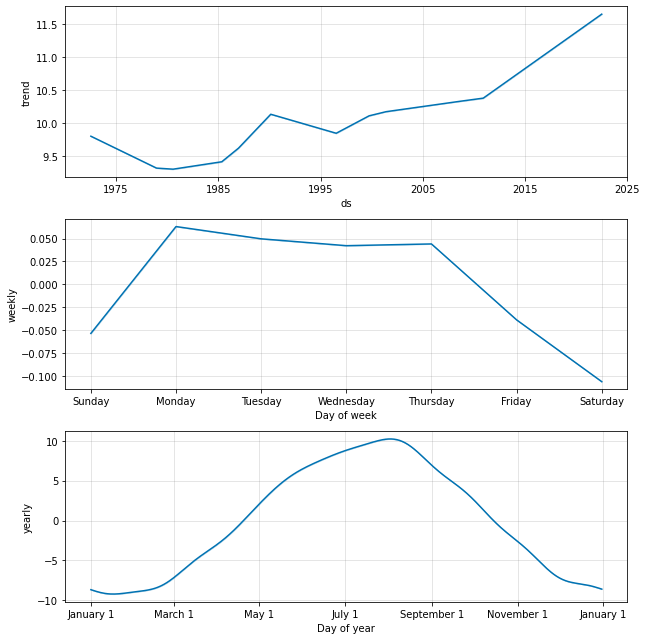

In [ ]:
fig2 = pr.plot_components(forecast)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(pr, forecast)


In [ ]:
plot_components_plotly(pr, forecast)

In [ ]:
from prophet.diagnostics import cross_validation
#df_cv = cross_validation(pr, initial='730 days', period='180 days', horizon = '365 days')


  0%|          | 0/96 [00:00<?, ?it/s]

12:21:12 - cmdstanpy - INFO - Chain [1] start processing
12:21:12 - cmdstanpy - INFO - Chain [1] done processing
12:21:15 - cmdstanpy - INFO - Chain [1] start processing
12:21:15 - cmdstanpy - INFO - Chain [1] done processing
12:21:18 - cmdstanpy - INFO - Chain [1] start processing
12:21:18 - cmdstanpy - INFO - Chain [1] done processing
12:21:23 - cmdstanpy - INFO - Chain [1] start processing
12:21:23 - cmdstanpy - INFO - Chain [1] done processing
12:21:27 - cmdstanpy - INFO - Chain [1] start processing
12:21:27 - cmdstanpy - INFO - Chain [1] done processing
12:21:32 - cmdstanpy - INFO - Chain [1] start processing
12:21:32 - cmdstanpy - INFO - Chain [1] done processing
12:21:38 - cmdstanpy - INFO - Chain [1] start processing
12:21:38 - cmdstanpy - INFO - Chain [1] done processing
12:21:42 - cmdstanpy - INFO - Chain [1] start processing
12:21:43 - cmdstanpy - INFO - Chain [1] done processing
12:21:47 - cmdstanpy - INFO - Chain [1] start processing
12:21:47 - cmdstanpy - INFO - Chain [1]

KeyboardInterrupt: 

In [ ]:
df_auto = pd.read_csv("data/TG_STAID002759.txt", parse_dates=True)

NameError: name 'pd' is not defined

In [ ]:
df_auto.columns = ['1', 'ds', 'y', '2']

In [ ]:
df_auto.drop(['1', '2'], axis=1, inplace=True)

In [ ]:
df_auto['ds'] = pd.to_datetime(df_auto['ds'], format="%Y%m%d")
df_auto['y'] = df_auto['y'] * 0.1

In [ ]:
df_auto = df_auto[-5000:]

In [ ]:
import pmdarima as pm

In [ ]:
df_auto.index = df_auto['ds']

In [ ]:
df_auto.drop(['ds'], axis=1, inplace=True)

In [ ]:
df_auto

y
ds              
2008-10-22   9.8
2008-10-23   8.2
2008-10-24   6.8
2008-10-25   8.8
2008-10-26  10.5
...          ...
2022-06-26  26.3
2022-06-27  28.1
2022-06-28  21.4
2022-06-29  21.4
2022-06-30  23.3

[5000 rows x 1 columns]

In [ ]:
m = pm.auto_arima(df_auto['y'], 
                  seasonal=True, 
                  maxiter=100,
                  d=1,
                  p=3,
                  m=365,
                  D=1,
                  n_jobs=-1,
                  trace=True)

NameError: name 'pm' is not defined

In [ ]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1083.194
Date:                Thu, 11 Aug 2022   AIC                           2174.387
Time:                        17:40:01   BIC                           2191.238
Sample:                             0   HQIC                          2181.000
                                - 500                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8923      0.050     17.870      0.000       0.794       0.990
ar.L2         -0.2714      0.040     -6.782      0.000      -0.350      -0.193
ma.L1         -0.8635      0.040    -21.506      0.000      -0.942      -0.785
sigma2         4.4931      0.224     20.076      0.000       4.054       4.932
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                38.26
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.09
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
df_auto['full_prediction_autoarima'] = m.predict_in_sample()

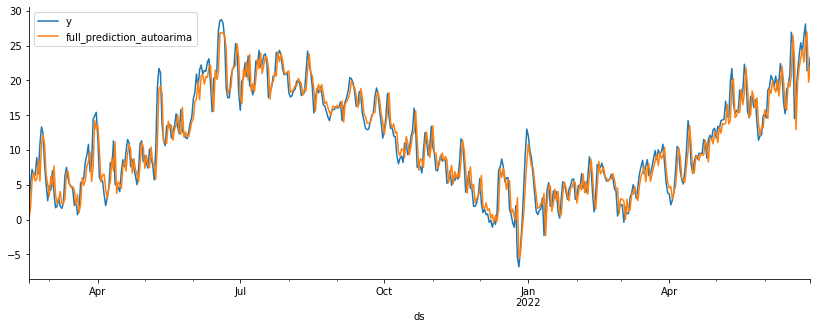

In [ ]:
import seaborn as sns
df_auto[['y', 'full_prediction_autoarima']].plot(figsize=(14,5),legend=True)
sns.despine()

In [ ]:
y_forecast, ci = m.predict(120, return_conf_int=True)

In [ ]:
y_forecast

array([23.6708671 , 23.48605627, 23.22048751, 23.03369087, 22.93910131,
       22.90540444, 22.90101244, 22.90624008, 22.91209673, 22.91590351,
       22.91771051, 22.91828956, 22.91831575, 22.91818195, 22.91805545,
       22.91797889, 22.91794492, 22.91793539, 22.9179361 , 22.91793933,
       22.91794202, 22.91794353, 22.91794416, 22.91794431, 22.91794427,
       22.9179442 , 22.91794414, 22.91794411, 22.9179441 , 22.9179441 ,
       22.9179441 , 22.9179441 , 22.9179441 , 22.9179441 , 22.9179441 ,
       22.9179441 , 22.9179441 , 22.9179441 , 22.9179441 , 22.9179441 ,
       22.9179441 , 22.9179441 , 22.9179441 , 22.9179441 , 22.9179441 ,
       22.9179441 , 22.9179441 , 22.9179441 , 22.9179441 , 22.9179441 ,
       22.9179441 , 22.9179441 , 22.9179441 , 22.9179441 , 22.9179441 ,
       22.9179441 , 22.9179441 , 22.9179441 , 22.9179441 , 22.9179441 ,
       22.9179441 , 22.9179441 , 22.9179441 , 22.9179441 , 22.9179441 ,
       22.9179441 , 22.9179441 , 22.9179441 , 22.9179441 , 22.91

In [ ]:
import numpy as np
timestamp = np.arange(len(df_auto) + len(y_forecast))

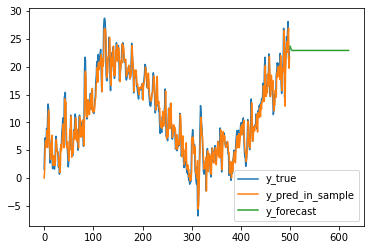

In [ ]:
plt.plot(timestamp[:len(df_auto)], df_auto['y'], label='y_true')
plt.plot(timestamp[:len(df_auto)], df_auto['full_prediction_autoarima'], label='y_pred_in_sample')
plt.plot(timestamp[len(df_auto):], y_forecast, label='y_forecast')
plt.legend()
None